In [1]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
import os

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.vaep.formula import value
import socceraction.vaep.formula as vaepformula
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
import tqdm
import random

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula

from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)


In [2]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
from socceraction.data.wyscout import PublicWyscoutLoader



In [3]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [4]:
comp = [
     #'England'
     #'France',
     'Germany',
     #'Italy',
     #'Spain'
]

In [5]:
##DA qui

In [6]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [8]:
selected_competitions = competitions[(competitions['country_name'] =='Germany')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
4,426,181137,Germany,German first division,male,2017/2018


### Append home and away goals to the game dataset

In [9]:
## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in selected_competitions['country_name']:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)
df_matches= df_matches.reset_index()

In [10]:
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    home_score.append(df_matches['teamsData'][i][home_id]['score'])
    away_score.append(df_matches['teamsData'][i][away_id]['score'])


In [11]:
df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

In [12]:
df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181137,2517036,"Bayern M\u00fcnchen - Stuttgart, 1 - 4",426,1,4
1,181137,2517037,"Hoffenheim - Borussia Dortmund, 3 - 1",426,3,1
2,181137,2517038,"Hertha BSC - RB Leipzig, 2 - 6",426,2,6
3,181137,2517039,"Freiburg - Augsburg, 2 - 0",426,2,0
4,181137,2517040,"Schalke 04 - Eintracht Frankfurt, 1 - 0",426,1,0


In [13]:
# Get games from all selected competitions
games = pd.concat([
    wyscout.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])

In [14]:
games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,2517036,426,181137,2018-05-12 13:30:00,34,2444,2445
1,2517037,426,181137,2018-05-12 13:30:00,34,2482,2447
2,2517038,426,181137,2018-05-12 13:30:00,34,2457,2975
3,2517039,426,181137,2018-05-12 13:30:00,34,2453,2481
4,2517040,426,181137,2018-05-12 13:30:00,34,2449,2462


In [15]:
match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

In [16]:
games[["home_team_id", "away_team_id", "game_date","home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,2444,2445,2018-05-12 13:30:00,1,4
1,2482,2447,2018-05-12 13:30:00,3,1
2,2457,2975,2018-05-12 13:30:00,2,6
3,2453,2481,2018-05-12 13:30:00,2,0
4,2449,2462,2018-05-12 13:30:00,1,0
...,...,...,...,...,...
301,2457,2445,2017-08-19 13:30:00,2,0
302,2450,2481,2017-08-19 13:30:00,1,0
303,2460,2455,2017-08-19 13:30:00,0,1
304,2451,2447,2017-08-19 13:30:00,0,3


In [17]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         306 non-null    int64         
 1   competition_id  306 non-null    int64         
 2   season_id       306 non-null    int64         
 3   game_date       306 non-null    datetime64[ns]
 4   game_day        306 non-null    int64         
 5   home_team_id    306 non-null    int64         
 6   away_team_id    306 non-null    int64         
 7   home_score      306 non-null    int64         
 8   away_score      306 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 23.9 KB


### Convert event to actions

# DO NOT RUN

In [18]:
### DO NOT RUN
#Convert events to SPADL 
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
atomic_actions = {}

for game in games_verbose:
    # load data
    teams.append(wyscout.teams(game.game_id))
    players.append(wyscout.players(game.game_id))
    events = wyscout.events(game.game_id)
    # convert data
    actions[game.game_id] = convert_to_actions(events, game.home_team_id)
    atomic_actions[game.game_id] = atomicspadl.convert_to_atomic(actions[game.game_id])

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|██████████| 306/306 [1:58:24<00:00, 23.22s/it]


In [19]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Ger"

In [20]:
# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = atomic_actions[game_id]

In [21]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [23]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,2444,Bayern M\u00fcnchen,FC Bayern M\u00fcnchen
1,2445,Stuttgart,VfB Stuttgart 1893
2,2482,Hoffenheim,TSG 1899 Hoffenheim
3,2447,Borussia Dortmund,BV Borussia 09 Dortmund
4,2457,Hertha BSC,Hertha BSC
5,2975,RB Leipzig,Rasen Ballsport Leipzig
6,2453,Freiburg,SC Freiburg
7,2481,Augsburg,FC Augsburg
8,2449,Schalke 04,FC Schalke 04
9,2462,Eintracht Frankfurt,Eintracht Frankfurt


In [25]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.country_name == "Germany") 
                  & (games.home_team_name_short == "Borussia Dortmund")
                  & (games.away_team_name_short== "Schalke 04")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2516847,209083443,0,1,3.683304,2447,25867,51.45,34.68,-13.65,8.84,0,0,pass,foot,P. Aubameyang,Borussia Dortmund,BV Borussia 09 Dortmund
1,2516847,209083443,1,1,4.954406,2447,3320,37.80,43.52,0.00,0.00,23,0,receival,foot,N. Şahin,Borussia Dortmund,BV Borussia 09 Dortmund
2,2516847,209083445,2,1,6.225507,2447,3320,37.80,43.52,-10.50,-28.56,0,0,pass,foot,N. Şahin,Borussia Dortmund,BV Borussia 09 Dortmund
3,2516847,209083445,3,1,7.653658,2447,14778,27.30,14.96,0.00,0.00,23,0,receival,foot,Ö. Toprak,Borussia Dortmund,BV Borussia 09 Dortmund
4,2516847,209083467,4,1,9.081809,2447,14778,27.30,14.96,10.50,-11.56,0,0,pass,foot,Ö. Toprak,Borussia Dortmund,BV Borussia 09 Dortmund


2017-11-25 14:30:00, BV Borussia 09 Dortmund - FC Schalke 04 : 4-4 , M. Götze 20'


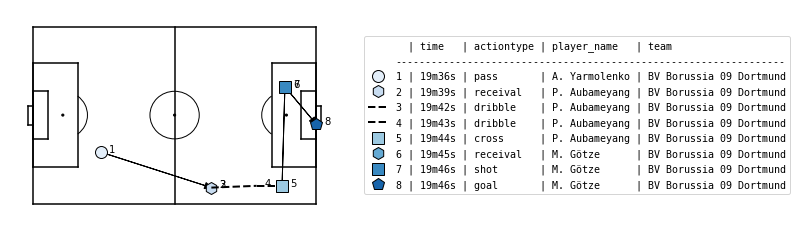

In [31]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][1:2].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [32]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [33]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 306


In [34]:
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(features_h5) as featurestore:
    for game in tqdm.tqdm(list(games.itertuples()),desc=f"Generating and storing features in {features_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        gamestates = fs.gamestates(atomicspadl.add_names(actions), 3)
        gamestates = fs.play_left_to_right(gamestates, game.home_team_id)

        X = pd.concat([fn(gamestates) for fn in xfns], axis=1)
        featurestore[f"game_{game.game_id}"] = X

Generating and storing features in /Users/leonardoyang/Desktop/data-fifa/Ger/atomic_features.h5: 100%|██████████| 306/306 [01:44<00:00,  2.94it/s]


In [35]:
yfns = [lab.scores, lab.concedes, lab.goal_from_shot]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(labels_h5) as labelstore:
    for game in tqdm.tqdm(list(games.itertuples()), desc=f"Computing and storing labels in {labels_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        Y = pd.concat([fn(atomicspadl.add_names(actions)) for fn in yfns], axis=1)
        labelstore[f"game_{game.game_id}"] = Y


Computing and storing labels in /Users/leonardoyang/Desktop/data-fifa/Ger/atomic_labels.h5: 100%|██████████| 306/306 [01:33<00:00,  3.29it/s]


### Compute Probabilities

In [36]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [37]:
#traingames, testgames = train_test_split(games, test_size=0.3, random_state=42, shuffle=False)

In [53]:
traingames, testgames = games, games

In [54]:
testgames

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score,country_name,competition_name,competition_gender,season_name,home_team_name_short,home_team_name,away_team_name_short,away_team_name
0,2517036,426,181137,2018-05-12 13:30:00,34,2444,2445,1,4,Germany,German first division,male,2017/2018,Bayern M\u00fcnchen,FC Bayern M\u00fcnchen,Stuttgart,VfB Stuttgart 1893
1,2517037,426,181137,2018-05-12 13:30:00,34,2482,2447,3,1,Germany,German first division,male,2017/2018,Hoffenheim,TSG 1899 Hoffenheim,Borussia Dortmund,BV Borussia 09 Dortmund
2,2517038,426,181137,2018-05-12 13:30:00,34,2457,2975,2,6,Germany,German first division,male,2017/2018,Hertha BSC,Hertha BSC,RB Leipzig,Rasen Ballsport Leipzig
3,2517039,426,181137,2018-05-12 13:30:00,34,2453,2481,2,0,Germany,German first division,male,2017/2018,Freiburg,SC Freiburg,Augsburg,FC Augsburg
4,2517040,426,181137,2018-05-12 13:30:00,34,2449,2462,1,0,Germany,German first division,male,2017/2018,Schalke 04,FC Schalke 04,Eintracht Frankfurt,Eintracht Frankfurt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2516741,426,181137,2017-08-19 13:30:00,1,2457,2445,2,0,Germany,German first division,male,2017/2018,Hertha BSC,Hertha BSC,Stuttgart,VfB Stuttgart 1893
302,2516745,426,181137,2017-08-19 13:30:00,1,2450,2481,1,0,Germany,German first division,male,2017/2018,Hamburger SV,Hamburger SV,Augsburg,FC Augsburg
303,2516746,426,181137,2017-08-19 13:30:00,1,2460,2455,0,1,Germany,German first division,male,2017/2018,Mainz 05,1. FSV Mainz 05,Hannover 96,Hannover 96
304,2516747,426,181137,2017-08-19 13:30:00,1,2451,2447,0,3,Germany,German first division,male,2017/2018,Wolfsburg,VfL Wolfsburg,Borussia Dortmund,BV Borussia 09 Dortmund


In [55]:
# 1. Select feature set X
xfns = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 1

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

X,Y = getXY(traingames, Xcols)
#print("X:", list(X.columns))
#print("Y:", list(Y.columns))
X = X.fillna(0)

Selecting label: 100%|██████████| 306/306 [00:02<00:00, 135.90it/s]


## Train 

In [56]:
%%time
# 3. train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = xgboost.XGBClassifier(n_estimators=48, max_depth=3, n_jobs=-3, verbosity=1)
    model.fit(X, Y[col])
    models[col] = model

CPU times: user 3min 43s, sys: 3.09 s, total: 3min 46s
Wall time: 1min 11s


In [57]:
testX, testY = getXY(testgames,Xcols)

Selecting label: 100%|██████████| 306/306 [00:02<00:00, 128.26it/s]


In [58]:
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

def evaluate(y, y_hat):
    p = sum(y) / len(y)
    base = [p] * len(y)
    brier = brier_score_loss(y, y_hat)
    print(f"  Brier score: %.5f (%.5f)" % (brier, brier / brier_score_loss(y, base)))
    ll = log_loss(y, y_hat)
    print(f"  log loss score: %.5f (%.5f)" % (ll, ll / log_loss(y, base)))
    print(f"  ROC AUC: %.5f" % roc_auc_score(y, y_hat))

for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)]
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])


### Y: scores ###
  Brier score: 0.00833 (0.81792)
  log loss score: 0.04082 (0.71183)
  ROC AUC: 0.87939
### Y: concedes ###
  Brier score: 0.00177 (0.91511)
  log loss score: 0.01073 (0.76573)
  ROC AUC: 0.88465


In [59]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(testgames.game_id, "Loading actions of each game"):
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 306/306 [00:03<00:00, 76.98it/s]


## VAEP

In [60]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(testgames))

nb of games: 306


In [61]:
A = []
for game in tqdm.tqdm(list(testgames.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 306/306 [00:19<00:00, 15.97it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [62]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:20]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
70,14817,R. Lewandowski,30.282381,30.054054,0.228327,1785
158,15795,K. Casteels,22.056456,0.989905,21.066551,2400
137,15265,T. Horn,21.975662,1.200849,20.774813,1924
309,173214,T. Werner,20.626368,20.169531,0.456835,1968
105,15032,R. Zieler,20.180481,1.297727,18.882755,2369
350,253822,J. Pavlenka,20.058943,1.054600,19.004343,2122
254,65180,M. Gregoritsch,19.515919,17.796383,1.719535,1990
173,16010,P. Tschauner,19.103981,0.417036,18.686945,2016
140,15292,M. Uth,18.951023,18.388638,0.562385,1597
131,15231,K. Volland,18.807188,17.500416,1.306772,2072


In [63]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 1500] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
69,14817,R. Lewandowski,30.282381,30.054054,0.228327,1785,2247,1.212912,1.203767,0.009145
289,134397,S. Gnabry,15.598071,15.128662,0.469409,1488,1561,0.899312,0.872248,0.027064
200,20475,A. Vidal,12.869358,11.407070,1.462288,2703,1510,0.767048,0.679892,0.087156
139,15292,M. Uth,18.951023,18.388638,0.562385,1597,2278,0.748723,0.726505,0.022219
267,86489,L. Alario,13.321259,12.829623,0.491635,1073,1624,0.738247,0.711001,0.027246
110,15085,S. Wagner,13.645165,13.325552,0.319614,1262,1667,0.736692,0.719436,0.017256
222,37948,A. Finnbogason,14.980635,14.841117,0.139518,1261,1887,0.714498,0.707843,0.006654
308,173214,T. Werner,20.626368,20.169531,0.456835,1968,2608,0.711799,0.696034,0.015765
260,70096,J. Rodríguez,12.909459,11.804366,1.105093,3441,1678,0.692402,0.633130,0.059272
259,69616,A. Rebić,13.687709,12.980290,0.707418,1517,1828,0.673903,0.639073,0.034829


In [64]:
stats.sort_values("defensive_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
157,15795,K. Casteels,22.056456,0.989905,21.066551,2400,3194,0.621503,0.027893,0.593610
136,15265,T. Horn,21.975662,1.200849,20.774813,1924,3236,0.611190,0.033398,0.577791
172,16010,P. Tschauner,19.103981,0.417036,18.686945,2016,2932,0.586411,0.012801,0.573610
349,253822,J. Pavlenka,20.058943,1.054600,19.004343,2122,3196,0.564864,0.029698,0.535166
227,49855,Y. Sommer,17.068644,0.737486,16.331158,2338,2758,0.556990,0.024066,0.532924
104,15032,R. Zieler,20.180481,1.297727,18.882755,2369,3204,0.566867,0.036453,0.530414
84,14914,M. Hitz,16.773996,0.340351,16.433645,1960,2925,0.516123,0.010472,0.505651
234,49968,R. Bürki,16.989302,0.827431,16.161873,2376,3113,0.491178,0.023922,0.467256
197,19525,A. Schwolow,17.228104,1.695069,15.533034,2421,3049,0.508537,0.050035,0.458502
245,55951,L. Hradecky,17.206982,1.344710,15.862272,2378,3213,0.481988,0.037667,0.444321


In [ ]:
#To do:
-Rimuovere portieri #
-Plot azione vaep #fatto
-Capire come calcola prob #fatto
-Iniziare a scrivere

In [65]:
#provato a usare stesso train e test in ger